# Wetterfrosch V1 Training

In [1]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt

/Users/markkeinhorster/.venv/tf_weather_service/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Die Wetterdaten werden mit Numpy geladen

In [2]:
from numpy import genfromtxt
rohdaten = genfromtxt(fname='../datasets/jena_climate_2009_2016.csv',
                      delimiter=',', 
                      skip_header=True, 
                      usecols=(range(1, 15)))

## Damit das neuronale Netz schneller konvergiert werden die Daten vorverarbeitet:

### Die Daten werden normalisiert

In [3]:
mean = rohdaten[:200000].mean(axis=0)
normalisiert = rohdaten - mean

### Die Daten werden zentriert

In [4]:
std = normalisiert[:200000].std(axis=0)
zentriert = normalisiert / std

### Plotten der Daten

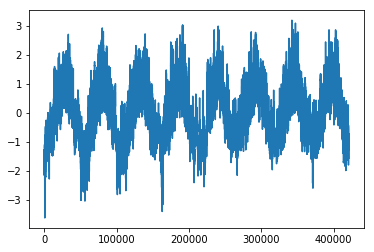

In [5]:
temp = zentriert[:, 1]  # temperature (in degrees Celsius)\n",
plt.plot(range(len(temp)), temp)
plt.show()

## Modell
Die Methode erstellt uns aus den zentrierten Daten Trainings- und Validierungsdatensatz

In [6]:
def generiere(data, lookback, delay):
    max_index = len(data) - delay - 1
    x = np.zeros((max_index-lookback, lookback, 14)).astype(np.float64)
    y = np.zeros((max_index-lookback)).astype(np.float64)
    for i in range(0+lookback, max_index):
        x[i-lookback] = data[i-lookback:i]
        y[i-lookback] = data[i+delay][1]
    return x, y

Die Parameter geben an wie die Daten, aussehen mit denen das Modell gefüttert wird

In [7]:
# Die Daten werden auf einen Datenpunkt pro 
# Stunde hochgerechnet
schrittweite = 6
stuendlich = zentriert[::schrittweite, :]

# Ein Datensatz besteht aus den letzten 5 Tagen der Vergangenheit 
# für eine Vorhersage für den nächsten Tag
zeitraum_vergangenheit = 120 # = 5 Tage = 5 * 24 Stunden
zeitraum_zukunft = 24 # = 1 Tag in die Zukunft vorhersagen

### Das Dataset wird in training, validation und test aufgesplittet

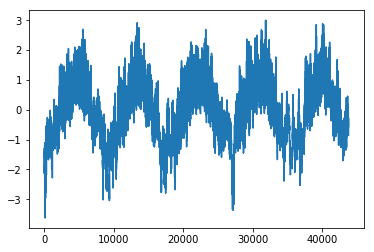

In [8]:
# Die Trainingsdaten
training = stuendlich[:43800, :]
training_x, training_y = generiere(training, 
                                   zeitraum_vergangenheit, 
                                   zeitraum_zukunft)
plt.plot(range(len(training[:, 1])), training[:, 1])
plt.show()

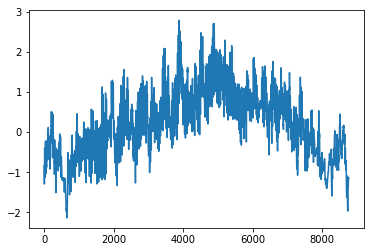

In [9]:
# Die Validierungsdaten
validierung = stuendlich[43800:52560]
validierung_x, validierung_y = generiere(training, 
                                         zeitraum_vergangenheit, 
                                         zeitraum_zukunft)
plt.plot(range(len(validierung[:, 1])), validierung[:, 1])
plt.show()

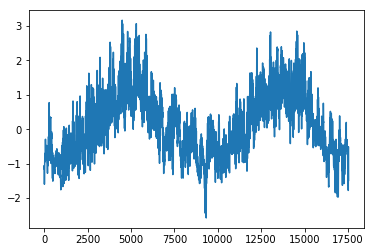

In [10]:
# Die Testdaten
test = stuendlich[52560:, :]
test_x, test_y = generiere(test, 
                           zeitraum_vergangenheit, 
                           zeitraum_zukunft)
plt.plot(range(len(test[:, 1])), test[:, 1])
plt.show()

## Das Keras-Modell für den WetterfroschV1 wird aufgebaut

In [11]:
wetterfrosch_v1 = keras.Sequential()
wetterfrosch_v1.add(keras.layers.GRU(units=16,
                                     activation='relu',
                                     dropout=0.1,
                                     recurrent_dropout=0.4,
                                     return_sequences=False,
                                     input_shape=(zeitraum_vergangenheit, stuendlich.shape[-1])))
wetterfrosch_v1.add(keras.layers.Dense(1))
wetterfrosch_v1.compile(optimizer=keras.optimizers.RMSprop(),
                        loss='mae')

In [12]:
history = wetterfrosch_v1.fit(x=training_x[:5],
                              y=training_y[:5],
                              epochs=1,
                              batch_size=32,
                              validation_data=(validierung_x, validierung_y),
                              shuffle=False,
                              verbose=2)

Train on 5 samples, validate on 43655 samples
Epoch 1/1
 - 23s - loss: 4.9188 - val_loss: 1.0843


## Das Modell wird mit den Testdaten evaluiert

In [13]:
evaluierung = wetterfrosch_v1.evaluate(x=test_x, y=test_y)
print evaluierung

17387/17387 [==============================] - 9s 541us/step
1.0717542606437571


## Das Modell wird nach dem Training im HDF5-Format gespeichert

In [14]:
wetterfrosch_v1.save('../keras_models/wetterfrosch_v1.h5')

In [15]:
prediction = wetterfrosch_v1.predict(test_x) * std[1] + mean[1]

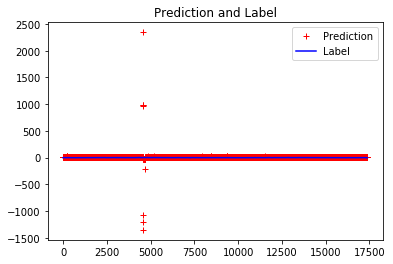

In [16]:
epochs = range(len(prediction))
plt.figure()
plt.plot(epochs, prediction, 'r+', label='Prediction')
plt.plot(epochs, test_y, 'b-', label='Label')
plt.title('Prediction and Label')
plt.legend()
plt.show()